In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, svm, ensemble

In [140]:
%matplotlib inline

# Exploration

Binary dataset, 564 of class 1 and 282 of class 2, together 846

1    564
2    282
Name: Class, dtype: int64


([<matplotlib.axis.XTick at 0x7f5135adbfa0>,
 [Text(0, 0, 'Class 2'), Text(1, 0, 'Class 1')])

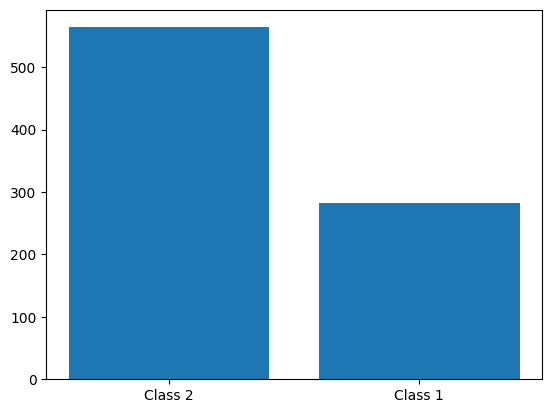

In [141]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.sample()
df.loc[:, "V1":"V3"]
classes = df.loc[:, "Class"].value_counts()
#print(classes, sum(classes))
y_pos = np.arange(len(classes), step=1)
print(classes)
plt.bar(y_pos, classes)
plt.xticks(y_pos, {"Class 1", "Class 2"})


In [142]:
#any(df.isnull())    # Missing values
df.info()

#df.isnull().sum()
df_test = df_test.fillna(df.mean())
df = df.fillna(df.mean())   # Fill missing values with the mean values
#df.loc[:, "Class"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846 entries, 3 to 1055
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      846 non-null    float64
 1   V2      846 non-null    float64
 2   V3      846 non-null    int64  
 3   V4      821 non-null    float64
 4   V5      846 non-null    int64  
 5   V6      846 non-null    int64  
 6   V7      846 non-null    int64  
 7   V8      846 non-null    float64
 8   V9      846 non-null    int64  
 9   V10     846 non-null    int64  
 10  V11     846 non-null    int64  
 11  V12     846 non-null    float64
 12  V13     846 non-null    float64
 13  V14     846 non-null    float64
 14  V15     846 non-null    float64
 15  V16     846 non-null    int64  
 16  V17     846 non-null    float64
 17  V18     846 non-null    float64
 18  V19     846 non-null    int64  
 19  V20     846 non-null    int64  
 20  V21     846 non-null    int64  
 21  V22     830 non-null    float64
 22  V

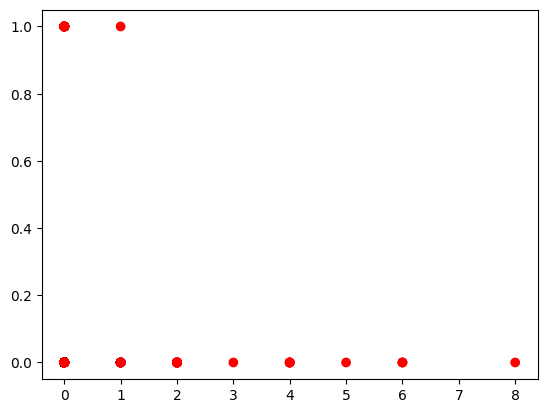

In [143]:
colors = ["red" if c == 1 else "blue" for c in df["Class"]]
labels = ["Class1" if c == 1 else "Class 2" for c in df["Class"]]
plt.scatter(x=df.loc[:,"V32"], y=df.loc[:,"V24"], c=colors)

Text(0.5, 0.98, 'Pairs of features, colored by the class')

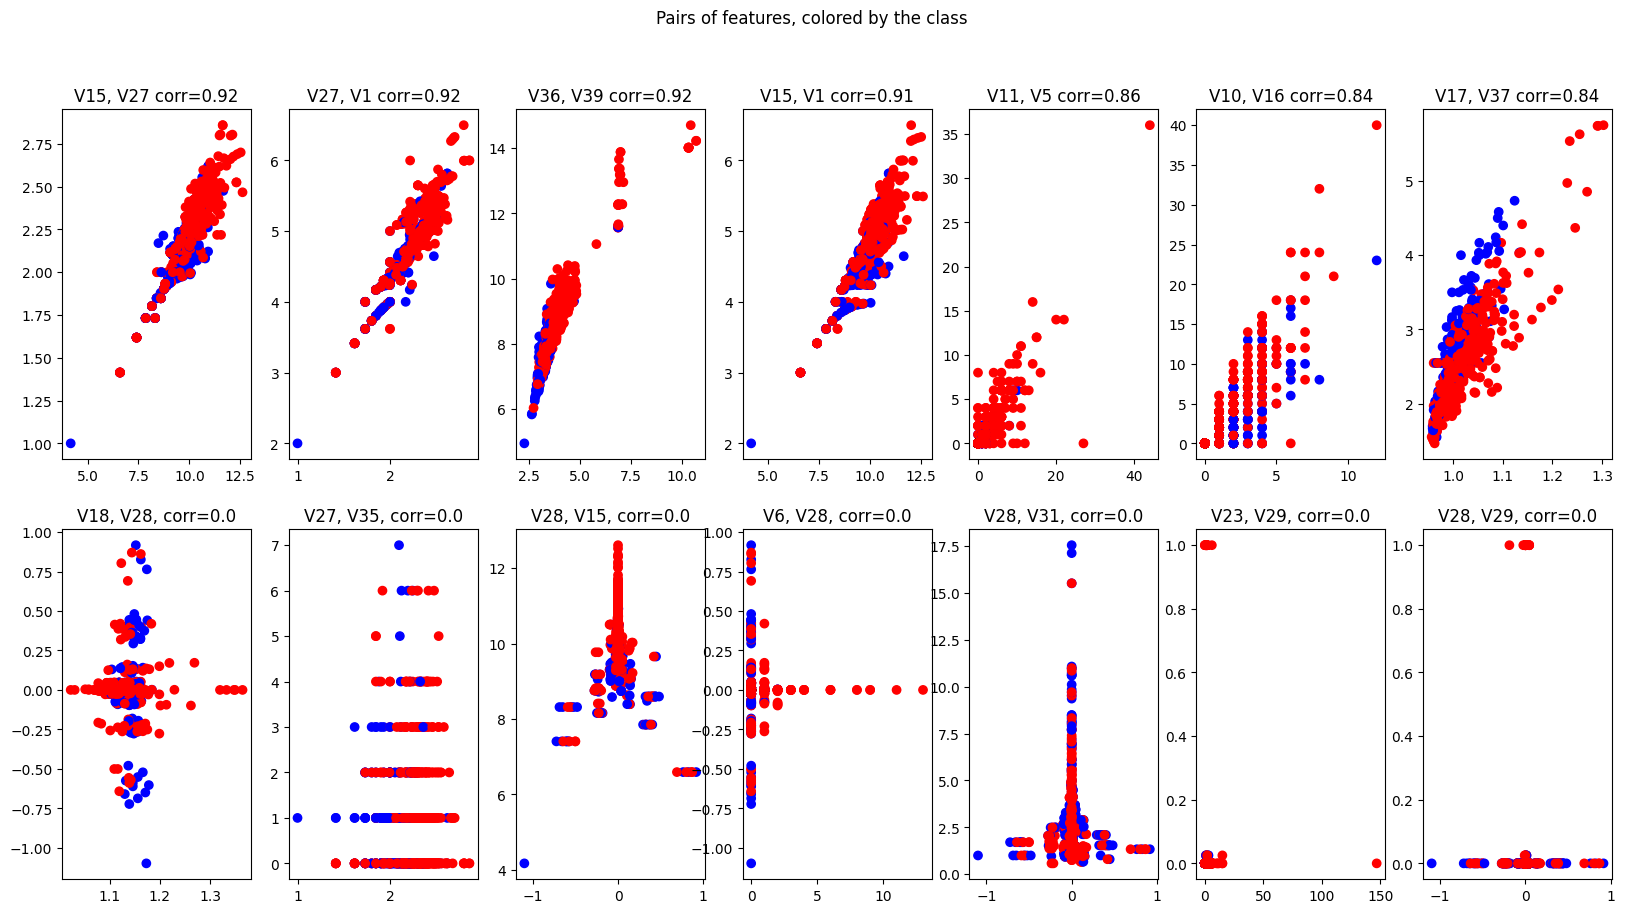

In [144]:
corr = abs(df.corr())   # Only need the magnitude

#corr = np.array(corr)   # Convert to numpy array
#corr = corr[~np.eye(corr.shape[0], dtype=bool)].reshape(corr.shape[0], -1)  # Remove diagonal elements
#corr = pd.DataFrame(corr) # Convert back to dataframe

corr = corr.unstack().sort_values(ascending=False)  # Convert to Series and sort

corr = corr.reset_index()   # Reset labels
corr.columns = ["feature1", "feature2", "corr"] # Rename labels

fig, ax = plt.subplots(2,7, figsize=(20,10))

displayed = set()

n = 0
for i in range(len(corr)):
    if n == 7:
        break
    pair = corr.iloc[i]
    if pair[0] and pair[1] and pair[0] != pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
        ax[0,n].scatter(x=df[pair[0]], y=df[pair[1]], c=colors, label=labels)  # Display pairs with highest correlations
        ax[0,n].set_title(f"{pair[0]}, {pair[1]} corr={round(pair[2], 2)}")
        
        displayed.add((pair[0], pair[1]))
        n += 1

n = 0
for i in range(len(corr)):
    if n >= 7:
        break
    
    pair = corr[::-1].iloc[i]
    if pair[0] and pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
        ax[1,n].scatter(x=df[pair[0]], y=df[pair[1]], c=colors, label=labels)  # Display pairs with lowest correlations
        ax[1,n].set_title(f"{pair[0]}, {pair[1]}, corr={round(pair[2], 2)}")
        
        displayed.add((pair[0], pair[1]))        
        n += 1
        
fig.suptitle("Pairs of features, colored by the class")

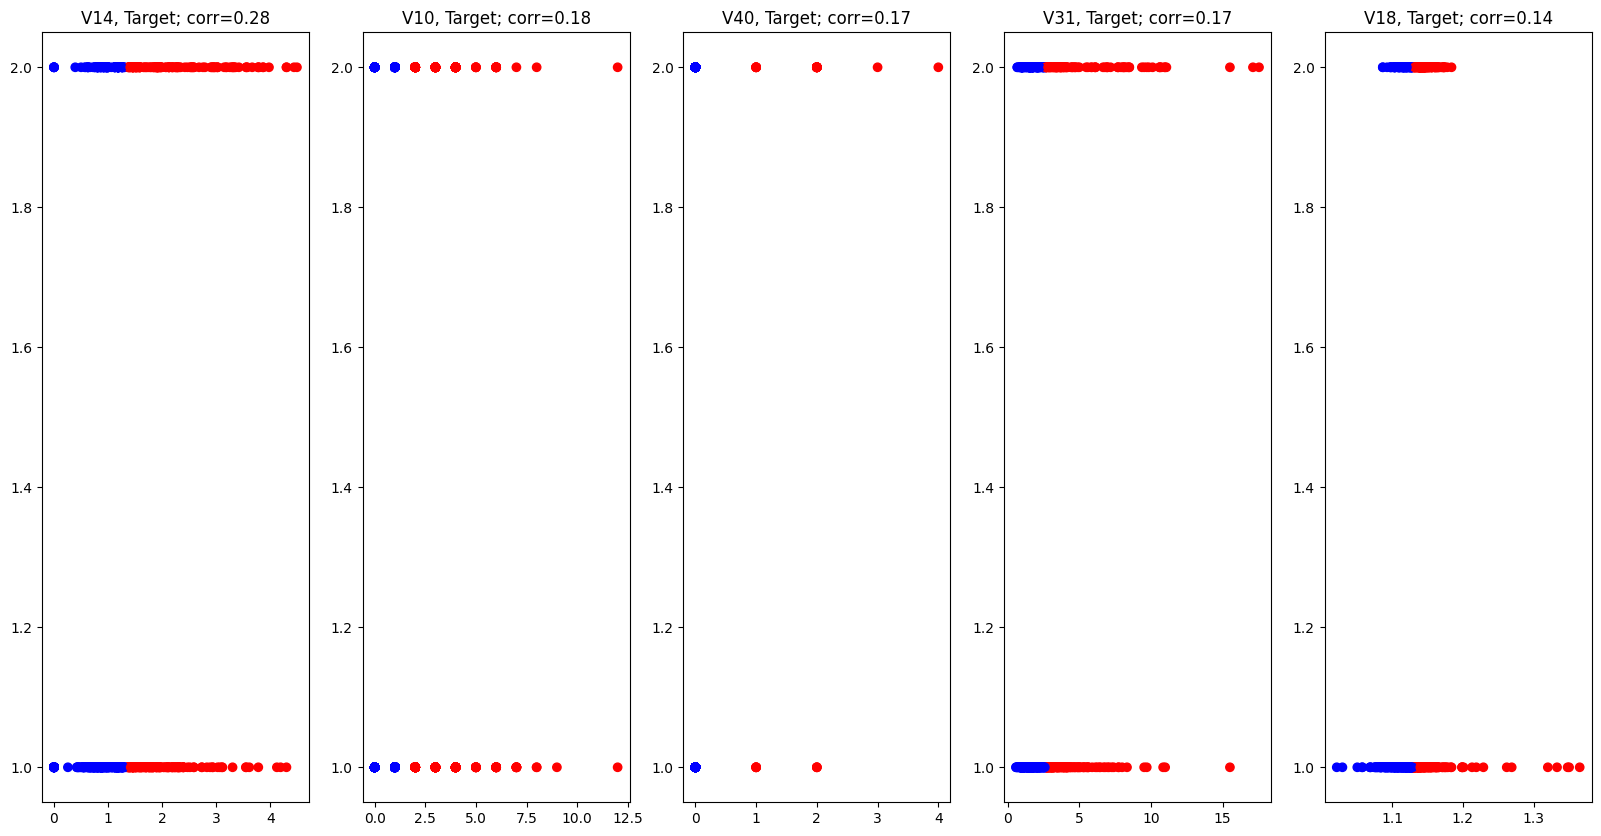

In [145]:
# Get correlation of each feature to the target class and plot the ones with highest correlation
fig, ax = plt.subplots(1,5, figsize=(20,10))

target_corr = df.corr()
pairs = []

for i in range(len(target_corr)-1):
    pairs.append((f"V{i+1}", target_corr.iloc[i,-1]))

pairs = sorted(pairs, key=lambda x: x[1])
pairs = pairs[::-1]

def get_colors(feature: str) -> np.ndarray:
    '''
        Colors the points based on their value compared to the mean
    '''
    mean = np.mean(df[feature])
    target_colors = ["red" if f > mean else "blue" for f in df[feature]]
    return target_colors
    
     

for i in range(5):
    ax[i].scatter(x=df.loc[:,pairs[i][0]], y=df.loc[:,"Class"], label=pairs[i][0], c=get_colors(pairs[i][0]))
    ax[i].set_title(f"{pairs[i][0]}, Target; corr={round(pairs[i][1], 2)}")
        
    

## TODO
* Feature selection
* ML models on all features and different subsets
* Feature transformations
* Result evaluation

# Modeling

### Majority classifier

In [146]:
class MajorityClassifier:
    '''
        Classifies the class with the majority classifier. Constructor takes in a pandas dataframe
    '''
    
    def __init__(self, df):
        self.df = df
        
    def fit(self):
        return self.df["Class"].mode()[0]
        

In [147]:
mc = MajorityClassifier(df)
mc.fit()

1

### Random classifier

In [148]:
class RandomClassifier:
    '''
        Classifies the class randomly. Constructor takes in a pandas dataframe
    '''
    def __init__(self, df):
        self.df = df
        
    def fit(self):
        return np.random.choice(self.df["Class"].values)

In [149]:
rc = RandomClassifier(df)
rc.fit()

2

### KNN - K Nearest Neighbors Model

In [224]:
# https://scikit-learn.org/stable/modules/neighbors.html
class KNeighbors:
    '''
        K Nearest Neigbors. Constructor takes in the train and test dataframe
    '''
    def __init__(self, train_df, test_df, n_neighbors=5):
        self.train_df = train_df
        self.test_df = test_df
        self.n_neighbors = n_neighbors
        
    def fit(self, n_neighbors=5, weights="uniform", metric="minkowski"):
        # Get train and test data
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
                
        # Get KNN object and fit the data
        clf = neighbors.KNeighborsClassifier(self.n_neighbors, weights=weights, metric=metric)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        return clf, accuracy

In [214]:
knn = KNeighbors(df, df_test, 3)
clf, knn_accuracy = knn.fit()
print("KNN accuracy: ", str(round(knn_accuracy, 3)) + "%")

KNN accuracy:  0.756%


KNN prediction plot

Text(0.5, 1.0, 'Diff')

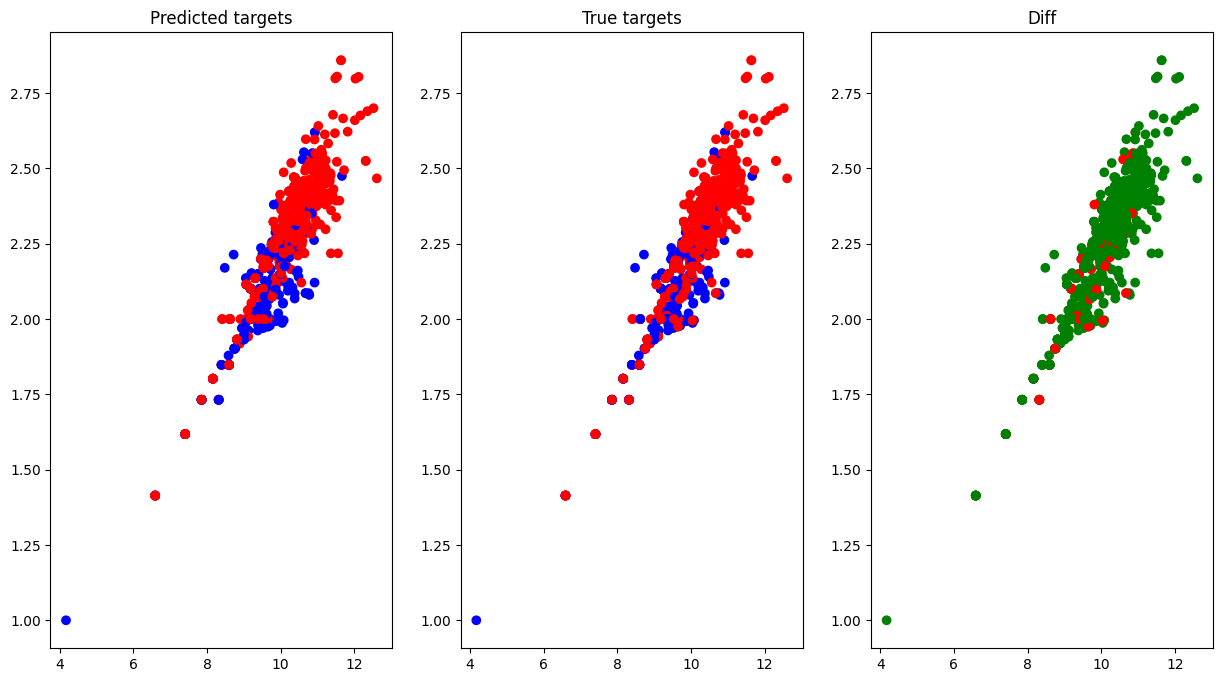

In [152]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])

fig, ax = plt.subplots(1,3, figsize=(15,8))

features = ["V15", "V27"]

predicted_colors = ["red" if target == 1 else "blue" for target in prediction]
diff_colors = ["green" if predicted == target else "red" for target, predicted in zip(df["Class"], prediction)]

ax[0].scatter(x=df[features[0]], y=df[features[1]], c=predicted_colors) 
ax[0].set_title("Predicted targets")

ax[1].scatter(x=df[features[0]], y=df[features[1]], c=colors)
ax[1].set_title("True targets")

ax[2].scatter(x=df[features[0]], y=df[features[1]], c=diff_colors)
ax[2].set_title("Diff")

Points as predicted by KNN and colored by actual target


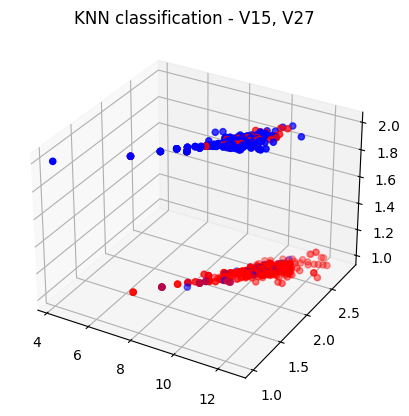

In [163]:
from mpl_toolkits.mplot3d import Axes3D

features = ["V15", "V27", "Class"]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"KNN classification - {features[0]}, {features[1]}")
print("Points as predicted by KNN and colored by the actual target")

### SVM - Support Vector Machine Model

In [209]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# https://scikit-learn.org/stable/modules/svm.html
class SupportVector:
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df
        
    def fit(self, kernel="linear", degree=2, gamma="auto"):
        # Get train and test data
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
        
        
        clf = sklearn.svm.SVC(kernel=kernel, degree=degree, gamma=gamma)
        clf.fit(X_train, y_train)
        
        accuracy = clf.score(X_test, y_test)
        
        return clf, accuracy

In [215]:
svm = SupportVector(df, df_test)
clf, svm_accuracy = svm.fit()
print("SVM accuracy:", str(round(svm_accuracy, 3)) + "%")

SVM accuracy: 0.847%


Points as predicted by SVM and colored by the actual target


Text(0.5, 0.5, 'V27')

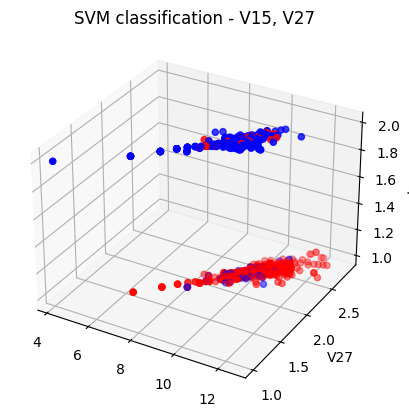

In [248]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])

features = ["V15", "V27", "Class"]

predicted_colors = ["red" if target == 1 else "blue" for target in prediction]
diff_colors = ["green" if predicted == target else "red" for target, predicted in zip(df["Class"], prediction)]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"SVM classification - {features[0]}, {features[1]}")
print("Points as predicted by SVM and colored by the actual target")
ax.set_zlabel("class")
ax.set_ylabel(features[1])

# Plot the seperating hyperplane - TODO
#hplane = clf.decision_function(df.loc[:, df.columns != "Class"])
#w = clf.coef_[0]
#a,b,c = -w[0] / w[1], -w[0] / w[2], -w[0] / w[3]
#
#xx = np.linspace(0, 14)
#yy = np.linspace(0, 14)
#XX, YY = np.meshgrid(xx, yy)
#ZZ = hplane#clf.decision_function()
#ZZ = ZZ.reshape(XX.shape)
#ax.plot_surface(XX, YY, ZZ, alpha=0.5, cmap='RdBu')

### Random forests

In [256]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html    
class RandomForest:
        def __init__(self, train_df, test_df):
            self.train_df = train_df
            self.test_df = test_df
            
        def fit(self, n_estimators=100, criterion="gini", max_depth=None):
            X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
            X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
            
            clf = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
            clf.fit(X_train, y_train)
            
            accuracy = clf.score(X_test, y_test)
            
            return clf, accuracy

In [257]:
rf = RandomForest(df, df_test)
clf, rf_accuracy = rf.fit()

print("Random Forest Classificator accuracy:", str(round(rf_accuracy, 2)) + "%")

Random Forest Classificator accuracy: 0.82%


In [265]:
test_colors = ["red" if c == 1 else "blue" for c in df_test["Class"]]

(209,)
Points as predicted by RF and colored by the actual target


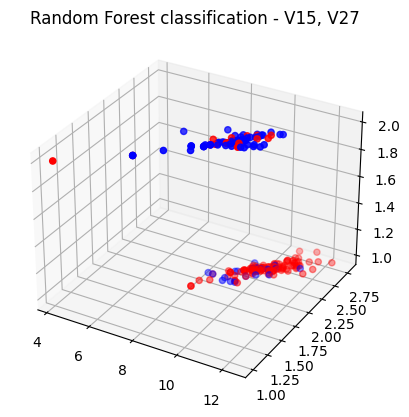

In [266]:
prediction = clf.predict(df_test.loc[:, df_test.columns != "Class"])
print(prediction.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs=df_test[features[0]], ys=df_test[features[1]], zs=prediction, c=test_colors)
ax.set_title(f"Random Forest classification - {features[0]}, {features[1]}")
print("Points as predicted by RF and colored by the actual target")